### Install and import these required packages

In [19]:
import itertools
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display


### Set number of epochs and batch size

In [110]:
num_epochs = 80
batch_size = 100

### Load MNIST Dataset

In [111]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset = datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_batches = len(dataloader)

### Model Architecture

In [112]:
# Q1. implement discriminator and generator as Multi-Layer Perceptrons
# Q2. add dropout layers and check network performance by plotting histograms


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # define hidden linear layers
        input_size=784
        hidden_dim=32
        output_size=1
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)
        return out
      
        

        
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
         # define hidden linear layers
        input_size=100
        hidden_dim=32
        output_size=784
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
         # all hidden layers
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

In [113]:
discriminator = Discriminator() #ursprünglich Discriminator().cuda()
generator = Generator() #usprünglich .cuda()

### Optimization

In [114]:
criterion = nn.BCEWithLogitsLoss()
lr = 0.0002
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

### Training

In [115]:

def train_discriminator(discriminator, images, fake_images):#ursprünglich mit real_labels und fake_labels
    ##TODO: fill-in the training procedure of discriminator##
    discriminator_optimizer.zero_grad()

    D_real = discriminator(images)
    batch_size = D_real.size(0)
    # label smoothing

    # smooth, real labels = 0.9
    labels = torch.ones(batch_size)*0.9

        
    
    # calculate loss
    real_score = criterion(D_real.squeeze(), labels)
    
    # Compute the discriminator losses on fake images        
    D_fake = discriminator(fake_images)
    
    
    batch_size = D_fake.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    # calculate loss
    fake_score = criterion(D_fake.squeeze(), labels)
        
    # add up loss and perform backprop
    discriminator_loss = real_score + fake_score
    discriminator_loss.backward()
    discriminator_optimizer.step()

    return discriminator_loss, real_score, fake_score

In [116]:
def train_generator(generator): #ursprünglich mit discriminator_outputs und rea_labels
    generator_optimizer.zero_grad()
         
    # Generate fake images
    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    fake_images = generator(z)
        
    # Compute the discriminator losses on fake images 
    # using flipped labels!
    D_fake = discriminator(fake_images)
    generator_loss = real_loss(D_fake) # use real loss to flip labels
        
    # perform backprop
    generator_loss.backward()
    generator_optimizer.step()

    return generator_loss

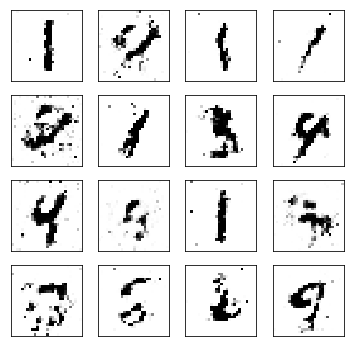

Epoch [80/80], Step[600/600], discriminator_loss: 1.2788, generator_loss: 1.0954, D(x): 0.75, D(G(z)): 0.53


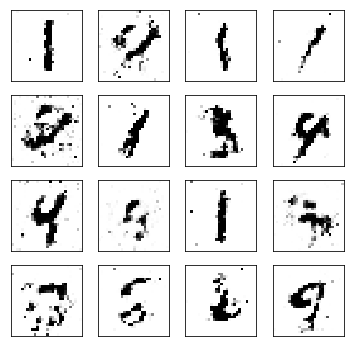

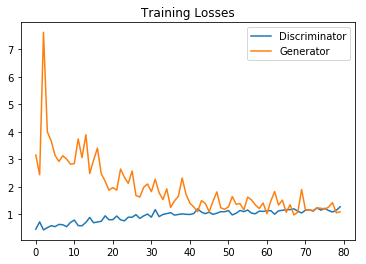

In [117]:
import numpy as np

# draw generated test samples from the input distribution
num_test_samples = 16

z_size = 100
losses = []

# grid figure to visualize generated MNIT digits
grid_size = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(grid_size, grid_size, figsize=(6, 6))
for i, j in itertools.product(range(grid_size), range(grid_size)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# figure counter
num_fig = 0

# sample test noise to generate test images
test_noise = Variable(torch.randn(num_test_samples, 100)) #.cuda()

for epoch in range(num_epochs):
    
    for n, (images, _) in enumerate(dataloader):
        images = F.upsample(images, size=(28,28))
        images = Variable(images) #images.cuda
        real_labels = Variable(torch.ones(images.size(0))) #.cuda()
        
        
        
        ##TODO: sample fake images from generator with random noise (not test_noise)
        fake_labels = Variable(torch.zeros(images.size(0))) #.cuda()
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = generator(z)
        
        #train the discriminator##
        discriminator_loss, real_score, fake_score = train_discriminator(discriminator, images, fake_images)
        
        ##TODO: sample again fake images from the generator with random noise and get discriminator output for this fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = generator(z)
       
        ##TODO: train the generator
        generator_loss = train_generator(generator)
        
        if (n+1) % 100 == 0:
            test_images = generator(test_noise)
            
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            time.sleep(1)
            plt.savefig('results/gan/%03d.png'%num_fig)
            num_fig += 1
            print('Epoch [%d/%d], Step[%d/%d], discriminator_loss: %.4f, generator_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, discriminator_loss.item(), generator_loss.item(),
                    real_score.data.mean(), fake_score.data.mean()))
            
    # append discriminator loss and generator loss
    losses.append((discriminator_loss.item(), generator_loss.item()))
            
    ##TODO: plot loss and score as historgram##
fig = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
            
    